In [2]:
import os
import numpy as np
from astropy.table import Table, vstack, join
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd

import matplotlib
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from matplotlib import rcParams
#rcParams['text.usetex'] = True
#rcParams["axes.grid"]   = False
rcParams["xtick.labelsize"] = 13
rcParams["ytick.labelsize"] = 13

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FormatStrFormatter
font = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 14}

from scipy.stats import linregress

# Additional test plots

In [5]:
# Complete Cantat-Gaudin+2020 Table 1
nntable = Table.read("data/CantatGaudin2020_table1.fits")
nntable["Cluster"] = [np.char.strip(a, ' ') for a in nntable["Cluster"]]
nntable_age_nonull = nntable[ nntable["AgeNN"]!= 0. ]

# Results of our analysis:
# - all OCs are at d < 1.5 kpc
# - There are 324 in total, 228 from Tarricq which in Cantat+20 catalogue have ages >50Myr, and 96 from Cantat+20
#   which in the age of this same catalogue have ages < 50Myr.
catalogue_obs_CantatTarricq = Table.read("data/Catalogue_observed_324OCs_CantatTarricq_MCMC_GMM.fits")
catalogue_obs_CantatTarricq["Cluster"] = [np.char.strip(a, ' ') for a in catalogue_obs_CantatTarricq["Cluster"]]

# Results for the simulated clusters
sim_OCs = Table.read("data/Catalogue_simulated_324OCs.fits")

## Results histograms MCMC analysis

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
#plt.axis([6,10,0,.9])
ax.set_xlabel(r"$f_{b}$", fontdict=font, fontsize=20)
ax.set_ylabel("Counts", fontdict=font, fontsize=20)
#plt.title("Age distribution", fontsize=16)
plt.xticks(np.arange(0.0, 0.9, step=0.1))
plt.yticks(np.arange(0, 140, step=10))
ax.tick_params(which="major", direction='inout', length=8.)
ax.tick_params(which="minor", direction='inout', length=5.)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.xlim(0.0, 0.8)
plt.ylim(0, 130)

binBoundaries = np.linspace(0.0, 0.7, round(0.7/0.05)+1)
binBoundaries_common = np.linspace(0.05, 0.40, round(0.35/0.05)+1)
binBoundaries_sim = np.linspace(0.05, 0.35, round(0.30/0.05)+1)
# --------------------------------------

# MCMC BF histogram for observed OCs
BFvals  = mergedtable["fb_50"]
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", ls="dashed", bins=binBoundaries, lw=1.5,
                               label="All 379 Gaia OCs", alpha=0.5, color="red", zorder=0)
# MCMC BF histogram for observed OCs
BFvals  = finaltable["fb_50"]
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", bins=binBoundaries, lw=5,
                               label="251 Gaia OCs (OK fit)", alpha=0.8, color="red", zorder=0)

# Try a log-normal fit
from scipy import stats
s, loc, scale = stats.lognorm.fit(BFvals, floc=0)
x_fit = np.linspace(0,0.8,100)
pdf_fitted = stats.lognorm.pdf(x_fit,s,loc,scale) #Gives the PDF
plt.plot(x_fit, 17*pdf_fitted, c="r", label="Log-normal fit ($\mu=0.18, \sigma=0.50$)", zorder=1, lw=2)
print(scale, s)

# first select OCs with OK Delta G
ok = (sim_OCs_MCMC_GMM["mean_sB_50"] <= 0.25) * (sim_OCs_MCMC_GMM["mean_sM_50"] <= 0.20) * (abs(sim_OCs_MCMC_GMM["mean_DG_50"]+0.75) <= 0.1)

BFvals  = (sim_OCs_MCMC_GMM["mean_fb_50"])
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", ls="dashed", bins=binBoundaries_sim, lw=1.5,
                               label="Simulated OCs", alpha=0.5, color="blue")  #filled
BFvals  = (sim_OCs_MCMC_GMM[ok]["mean_fb_50"])
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", bins=binBoundaries_sim, lw=3,
                               label="Simulated OCs (OK fit)", alpha=0.8, color="blue")  #filled

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [1,2,0,3,4]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
           loc="upper right", prop={"family":"serif", 'size': 16}, framealpha=0.0)

#plt.tight_layout()
plt.savefig("im/MCMC_BF_histo.png", dpi=300)

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.set_xlabel(r"${\Delta \rm G}$  [mag]", fontdict=font, fontsize=20)
ax.set_ylabel("Counts", fontdict=font, fontsize=20)
plt.xticks(np.arange(-1.0, -0.3, step=0.1))
ax.tick_params(which="major", direction='inout', length=8.)
ax.tick_params(which="minor", direction='inout', length=5.)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
plt.xlim(-1.05, -0.35)

binBoundaries = np.linspace(-1.0, -0.4, round(0.6/0.025)+1)
binBoundaries_common = np.linspace(-0.8, -0.4, round(0.4/0.025)+1)
binBoundaries_sim = np.linspace(-0.75, -0.4, round(0.35/0.025)+1)
# --------------------------------------
# MCMC deltaG histogram for observed OCs
BFvals  = mergedtable["DG_50"]
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", bins=binBoundaries, lw=2.5,
                               label="Gaia OCs", alpha=0.5, color="red")
# MCMC deltaG histogram for observed OCs (OK fit)
BFvals  = finaltable["DG_50"]
vals, bins, patches = plt.hist(BFvals, density=False, histtype="stepfilled", bins=binBoundaries, lw=4,
                               label="Gaia OCs", alpha=0.8, color="red")

# MCMC deltaG histogram for simulated OCs
BFvals  = (sim_OCs_MCMC_GMM["mean_DG_50"])
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", bins=binBoundaries_sim, lw=2.5,
                               label="Simulated OCs", alpha=0.5, color="blue")  #filled
# MCMC deltaG histogram for simulated OCs (OK)
BFvals  = (sim_OCs_MCMC_GMM[ok]["mean_DG_50"])
vals, bins, patches = plt.hist(BFvals, density=False, histtype="stepfilled", bins=binBoundaries_sim, lw=2.5,
                               label="Simulated OCs (OK fit)", alpha=0.5, color="blue")  #filled

#plt.legend(loc="upper right", prop={"family":"serif", 'size': 14}, framealpha=0.0)

plt.annotate("Reliable measurements", (-.72, 145), xytext=(-.68, 170), xycoords='data', 
             textcoords=None, arrowprops={"width":1, "headwidth":4.5, "color":"k"}, annotation_clip=None, 
             fontsize=14, fontfamily='serif')
plt.annotate("Differential reddening", (-.95, 10), xytext=(-1.03, 70), xycoords='data', 
             textcoords=None, arrowprops={"width":1, "headwidth":4.5, "color":"k"}, annotation_clip=None, 
             fontsize=14, fontfamily='serif')
plt.annotate("Problematic fits", (-.425, 50), xytext=(-.55, 120), xycoords='data', 
             textcoords=None, arrowprops={"width":1, "headwidth":4.5, "color":"k"}, annotation_clip=None, 
             fontsize=14, fontfamily='serif')
#plt.tight_layout()
plt.savefig("im/MCMC_deltaG_histo.png", dpi=300)

## Histogram of $q_{\rm lim}$ from the simulations

In the simulations we know exactly how many single and binary stars there are, and which mass ratios they have. 
We can therefore calculate, for a given limiting $q_{\rm lim}$, the binary fraction, and compare it to the one 
inferred with MCMC. The optimal value (where ground truth and MCMC match) is called $q_{\rm lim}^{\rm sim}$:

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
#plt.axis([6,10,0,.9])
ax.set_xlabel(r"$q_{\rm lim}^{\rm sim}$", fontdict=font, fontsize=20)
ax.set_ylabel("Counts", fontdict=font, fontsize=20)
#plt.title("Age distribution", fontsize=16)
plt.xticks(np.arange(0.0, 0.9, step=0.1))
plt.yticks(np.arange(0, 140, step=10))
ax.tick_params(which="major", direction='inout', length=8.)
ax.tick_params(which="minor", direction='inout', length=5.)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.xlim(0.15, 0.75)
plt.ylim(0, 80)

binBoundaries = np.linspace(0.2, 0.7, round(0.7/0.05)+1)
binBoundaries_common = np.linspace(0.05, 0.40, round(0.35/0.05)+1)
binBoundaries_sim = np.linspace(0.05, 0.35, round(0.30/0.05)+1)
# --------------------------------------

# MCMC BF histogram for simulated OCs

# first select OCs with OK Delta G
#ok = (sim_OCs_MCMC_GMM["mean_sB_50"] <= 0.25) * (sim_OCs_MCMC_GMM["mean_sM_50"] <= 0.20) * \
#     (abs(sim_OCs_MCMC_GMM["mean_DG_50"]+0.75) <= 0.05)

BFvals  = (sim_OCs_MCMC_GMM["m_r_closer_BF_to_sim_MCMC"])
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", bins=binBoundaries, lw=2.5,
                               label="Simulated OCs", alpha=0.8, color="blue")  #filled
BFvals  = (sim_OCs_MCMC_GMM[ok]["m_r_closer_BF_to_sim_MCMC"])
vals, bins, patches = plt.hist(BFvals, density=False, histtype="stepfilled", bins=binBoundaries, lw=2.5,
                               label="Simulated OCs (OK fit)", alpha=0.5, color="blue")  #filled

percentiles = np.percentile(sim_OCs_MCMC_GMM[ok]["m_r_closer_BF_to_sim_MCMC"], [16, 50, 84])
for ii in [0,1,2]:
    if ii == 1:
        plt.axvline(percentiles[ii], c="k", alpha=.8, ls="dashed")
    else:
        plt.axvline(percentiles[ii], c="grey", alpha=.5, ls="dashed")

plt.legend(prop={"family":"serif", 'size': 18}, framealpha=0.0, loc="upper left")

#plt.tight_layout()
plt.savefig("im/MCMC_qlim_histo.png", dpi=300)

## Mass dependence

324 clusters with ages and ok f_b uncertainties


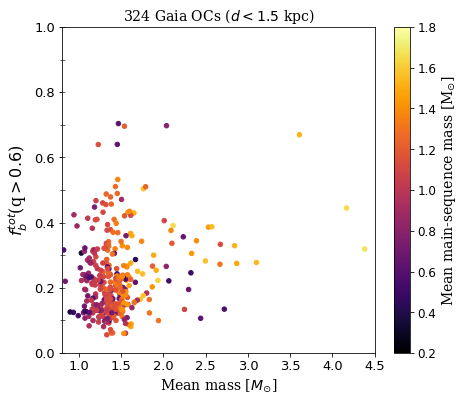

In [21]:
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
plt.axis([0.8,4.5,0,1.00])
ax.set_xlabel(r"Mean mass [$M_{\odot}$]", fontdict=font)
ax.set_ylabel(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=16, fontdict=font)

ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which="minor", direction='inout', length=5.)

ok = (catalogue_obs_CantatTarricq["AgeNN_1"] > 0) & \
(catalogue_obs_CantatTarricq["fb_sigu"]+catalogue_obs_CantatTarricq["fb_sigl"] < maximum_bf_sigu_sigl_sum)
print(sum(ok), "clusters with ages and ok f_b uncertainties")

sc = ax.scatter(0.5*(catalogue_obs_CantatTarricq["mass_max"][ok]+catalogue_obs_CantatTarricq["mass_min"][ok]), 
                catalogue_obs_CantatTarricq["fb_tot_greater06"][ok],
                marker="o", c=catalogue_obs_CantatTarricq["mean_mass"], vmin=0.2, vmax=1.8,
                s=20, label="_nolegend_", cmap="inferno", zorder=10)
cb = plt.colorbar(sc)
cb.set_label(r"Mean main-sequence mass [M$_{\odot}$]", fontsize=14, fontdict=font)
cb.ax.tick_params(labelsize=12)

plt.title(r"324 Gaia OCs ($d<1.5$ kpc)", fontdict=font)

# Overplot running median
total_bins = 7
bins = np.linspace(0.8, 4, total_bins)
delta = bins[1]-bins[0]
stat = np.zeros((total_bins, 3))   # list of total_bins elements, with 3 elements each

# automatic calculation of the quantiles:
for k in np.arange(total_bins-1):
    stat[k,:] = np.quantile(catalogue_obs_CantatTarricq["fb_tot_greater06"][ok & (0.5*(catalogue_obs_CantatTarricq["mass_max"]+catalogue_obs_CantatTarricq["mass_min"]) > bins[k]) & (0.5*(catalogue_obs_CantatTarricq["mass_max"]+catalogue_obs_CantatTarricq["mass_min"]) < bins[k+1])],
                         [.16,.50,.84])
# y axis has the middle component (50th percentile, median) for all rows: for all middeling positions of the bins.
#plt.errorbar(bins+delta/2,stat[:,1], yerr=[stat[:,1]-stat[:,0], stat[:,2]-stat[:,1]], c="b", fmt="none", zorder=20)
# it also plots the 9th errorbar, but as it is full of 0's, we don't see it.
# It si necessary to plot bins without the last element, because for this no stats is calculated (it is the last right border)
#plt.plot(bins[:-1]+delta/2,stat[:-1, 1],'b--',lw=4, alpha=.8, zorder=30)

plt.savefig("im/mass_BF_tot_scatterplot_auxmeanmass.png", dpi=300)

241 clusters with ages and ok f_b uncertainties


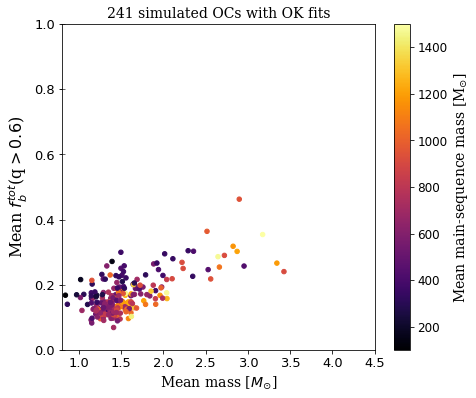

In [22]:
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
plt.axis([0.8,4.5,0,1.00])
ax.set_xlabel(r"Mean mass [$M_{\odot}$]", fontdict=font)
ax.set_ylabel(r"Mean $f_{b}^{ tot}$(q$>0.6$)", fontsize=16, fontdict=font)

ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.tick_params(which="minor", direction='inout', length=5.)

ok = (sim_OCs_MCMC_GMM["logAge"] > 0) & (sim_OCs_MCMC_GMM["mean_DG_50"] < -0.55) & \
(sim_OCs_MCMC_GMM["mean_fb_sigu"]+sim_OCs_MCMC_GMM["mean_fb_sigl"] < maximum_bf_sigu_sigl_sum)
print(sum(ok), "clusters with ages and ok f_b uncertainties")

sc = ax.scatter(0.5*(sim_OCs_MCMC_GMM["mass_max"][ok]+sim_OCs_MCMC_GMM["mass_min"][ok]), 
                sim_OCs_MCMC_GMM["mean_fb_tot_greater06"][ok],
                marker="o", c=sim_OCs_MCMC_GMM[ok]["DistPc"], vmin=100, vmax=1500,
                s=20, label="_nolegend_", cmap="inferno", zorder=10)
cb = plt.colorbar(sc)
cb.set_label(r"Mean main-sequence mass [M$_{\odot}$]", fontsize=14, fontdict=font)
cb.ax.tick_params(labelsize=12)

plt.title(r""+str(sum(ok))+" simulated OCs with OK fits", fontdict=font)

# Overplot running median
total_bins = 7
bins = np.linspace(0.8, 3.5, total_bins)
delta = bins[1]-bins[0]
stat = np.zeros((total_bins, 3))   # list of total_bins elements, with 3 elements each

# automatic calculation of the quantiles:
for k in np.arange(total_bins-1):
    stat[k,:] = np.quantile(sim_OCs_MCMC_GMM["mean_fb_tot_greater06"][ok & (0.5*(sim_OCs_MCMC_GMM["mass_max"]+sim_OCs_MCMC_GMM["mass_min"]) > bins[k]) & \
                                                                            (0.5*(sim_OCs_MCMC_GMM["mass_max"]+sim_OCs_MCMC_GMM["mass_min"]) < bins[k+1])],
                         [.16,.50,.84])
plt.savefig("im/sim_mass_BF_tot_scatterplot_auxmeanmass.png", dpi=300)